#NEED TO SAMPLE THE FILE TO DEVELOP 
awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01 || FNR==1) print $0}' filename


In [220]:
!pwd


/home/dliu/lambda/unit-2/DS-Unit-2-Build-dmhliu


In [221]:
import pandas as pd
import numpy as np
import math 
import pprint

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 100)


In [222]:
# Get Pandas Profiling Report
import pandas_profiling
#pandas_profiling.ProfileReport(df)

In [223]:
df = pd.read_csv('reduced1.csv', header=0, error_bad_lines=False, engine="python");

Skipping line 2: ',' expected after '"'
Skipping line 21: ',' expected after '"'
Skipping line 23: ',' expected after '"'
Skipping line 30: ',' expected after '"'
Skipping line 183: ',' expected after '"'
Skipping line 199: ',' expected after '"'
Skipping line 244: ',' expected after '"'
Skipping line 276: ',' expected after '"'
Skipping line 284: ',' expected after '"'
Skipping line 297: ',' expected after '"'
Skipping line 313: ',' expected after '"'
Skipping line 327: ',' expected after '"'
Skipping line 396: ',' expected after '"'
Skipping line 467: ',' expected after '"'
Skipping line 546: ',' expected after '"'
Skipping line 625: ',' expected after '"'
Skipping line 677: ',' expected after '"'
Skipping line 738: ',' expected after '"'
Skipping line 922: ',' expected after '"'
Skipping line 943: ',' expected after '"'
Skipping line 975: ',' expected after '"'
Skipping line 983: ',' expected after '"'
Skipping line 996: ',' expected after '"'
Skipping line 1052: ',' expected after 

In [224]:
columns = df.columns
str_cols = df.select_dtypes('object').columns


In [225]:
delete = [s for s in df.columns.values if 'DELETE - ' in s]   #columns have delete in name
boundary = [s for s in df.columns.values if 'Boundary' in s]   #columns have boundary in name
floatcols = df.select_dtypes(include='float64').columns


In [226]:
class Wrangler:
    #class vars
    dropcols = list() #list to store columns to drop
    droprows = dict() #row boolean filters
    dropcols_post = list()
    bool_filters = dict() # list of name, expression tuples , or dict?

    encoders = dict() # colname, function to be applied to elements
    def calc_lt_005_cat(self, df): 
        return df.Category.value_counts()[df.Category.value_counts(normalize=True).values < .005]

    def __init__(self, data):
        self.raw_df = data.copy()  
        self.working = self.raw_df.copy()
    #methods
    def set_data(self,df):          # reset dataframe to new df
        print('set data to df', df.shape)
        self.raw_df= df.copy()
        self.working = self.raw_df.copy()
        return working
    def add_to_dropcols(self,labels):
        for l in labels:
            if l in self.dropcols:
                print('error column already in dropcols list')
                break
                return self.dropcols
        self.dropcols.extend(labels)
        return self.dropcols

    def get_dropcols(self):
        if not self.dropcols: 
            print('no columns to drop')
        return self.dropcols
    def clear_dropcols(self):
        self.dropcols=list()
        return True
    def get_nancols(self, df=None, store=False):
        if df is None: 
            df=self.working
        cols =df.columns
        nc=df[cols].isnull().sum().index.tolist()
        if store:
            self.nancols = nc
        return nc
    def add_to_droprows(self, name, expr):
        self.droprows[name] = expr 
        return self.droprows.keys()

    def get_params(self):
        pass
        #return all wrangler settings 
    def set_nanval(self):
        pass 
       # self.nanvals add self to 
    def add_bool_filter(self, label, expr):  #
        self.bool_filters[label] = expr
        return self.bool_filters
    def add_encoding(self, label, mapper):
        try:
            label in self.working.columns
        except:
            print(label, 'not found in working copy, may have been dropped')
            assert label in self.raw_df.columns
        self.encoders[label]= mapper

#internal 
    def drop_rows_by_mask(self,df=None,labels=None):
        if df is None:
            df=self.working
        if labels is None:
            print('dropping all in droprows..')
            if self.droprows:
                labels = list(self.droprows.keys())
        mask = self.droprows[labels[0]]  #get first boolean mask
        for l in labels: 
            print('\napplying mask: ',l )
            mask = mask | self.droprows[l]   #or them all together
        df.drop(index=df[mask].index,inplace=True)
        
        return df 
    def drop_dupes(self, df=None):
        if df is None:
            df=self.working
        todropindex = df[df.duplicated()].index
        df.drop(todropindex,axis=0, inplace=True)
        return df

    def drop_columns(self,df=None, list=None):
        if df is None:
            df = self.working
        if list is None: 
            list= self.dropcols
        #todo check dropcols present in df.columns
        return df.drop(labels=self.dropcols, axis=1, inplace=True)
    def drop_columns_post(self):
        drop_columns(list=dropcols_post)
    def bin_othercats(self):
        df = self.working
        othercats = self.calc_lt_005_cat(df).index.tolist()
        df['Category'] = df.Category.map(lambda cat : 'other' if cat in othercats else cat)
    def encode(self,df=None, label=None, fun=None):                      
        if df is None: 
            df=self.working
            print('/n Encoding, changing working copy..')
        if fun is None:
            fun = list(self.encoders.keys()) 
            for k in fun:
                print('  ... encoding column: ',k)
                df[k] = df[k].map(self.encoders[k])
        else:
            df[label] = df[label].map(fun)
        return df
    def to_datetime(self, cols=None, df=None):
        if df is None:
            df=self.working
            print('\nworking df is being changed..')
        if cols is None:
            cols=self.dt_cols
        for c in cols:
            print('converting',c,'to datetime')
            try:
                df[c] = pd.to_datetime(df[c],infer_datetime_format=True)  #inplace 
            except: 
                print('error - possible this column needs cleaning')
        return df

       
    def make_feature(self,newlabel,input,fun):      #make or overwrite column newlabel
        df=self.working
        try:
            df[newlabel] = df[input].apply(fun, axis=1)  #or map or tranform?
            print('\nadded feature:', newlabel)
        except:
            print('there was a problem, not added!!')
            return False
        return True
    def calc_open_cases(self, sometime):  #input time
        df= self.working[['CaseID','Opened','Closed']]
        opened_prior = df['Opened'] < sometime        # cases opened before it,
        not_closed_prior = ~(df['Closed'] < sometime) # not closed, 
        open_at_thattime = opened_prior & not_closed_prior  #and 
        return open_at_thattime.sum()
    
    order_default = [drop_rows_by_mask,
                    drop_columns, 
                    drop_dupes,
                    encode,
                    drop_columns_post]   #list of methods in order of application

    def wrangle(self, df=None):

        if df is None:
            df =self.raw_df.copy() # start from the beginning 
            result = df
            print('will apply :', self.order_default)
            for f in self.order_default:
                print('level')
                result = f(result)
        return result
## instantiate  a wrangler and setup drops and encoding. 
## run methods on the internal working copy to iterate 
## to wrangler.entire workflow, run wrangle() with the default to process the orginal data in order defined 
## 

In [227]:
##define settings here 
wrangler = Wrangler(df)   
wrangler.clear_dropcols()

wrangler.add_to_dropcols(delete)

wrangler.add_to_dropcols(['Point'])  ##redundant w/ lat long, but may use for geospatial later


missing_to_0 = lambda x : 0 if math.isnan(x) else int(x)   #convert float to int, nan to zeros
missing_to_unk =  lambda x : x if type(x) == str else 'missing'  #for strings 

wrangler.add_encoding('Request Details', missing_to_unk)
wrangler.add_encoding('Neighborhood', missing_to_unk)
wrangler.add_encoding('Police District', missing_to_unk)
wrangler.add_to_dropcols(['Parks Alliance CPSI (27+TL sites)','Supervisor District'])
wrangler.add_to_dropcols(['Central Market/Tenderloin Boundary Polygon - Updated'])
wrangler.add_to_dropcols(['Civic Center Harm Reduction Project Boundary',
       'Fix It Zones as of 2017-11-06 ', 'Invest In Neighborhoods (IIN) Areas',
       'Fix It Zones as of 2018-02-07','SF Find Neighborhoods',
       'CBD, BID and GBD Boundaries as of 2017','Current Supervisor Districts',
       'Central Market/Tenderloin Boundary', 'Areas of Vulnerability, 2016',
       'HSOC Zones as of 2018-06-05', 'OWED Public Spaces'])

wrangler.add_encoding('Analysis Neighborhoods', missing_to_0)  #convert neigborhoods
wrangler.add_encoding('Neighborhoods', missing_to_0) 
wrangler.add_encoding('Street', missing_to_unk )
wrangler.add_encoding('Media URL', lambda x : 'present' if type(x) == str else 'missing')


In [228]:

def caseid_to_int (x):    #convert good caseids to int, bad to zero for drop
    try:
        i = int(x)
    except:
        i = 0   
        return 0      #strings are converted to zero for dropping 
    return i
wrangler.droprows['drop_missing_caseid'] = df.CaseID.map(caseid_to_int) == 0    #mask to drop rows with no caseid
wrangler.add_encoding('CaseID', caseid_to_int)        #can be done any order


In [229]:

##drop 

nopen = df.Opened.isnull()    # bad records 

wrangler.droprows['drop null open date'] = nopen #migh be fixed by  missing caseID?

nclosed= df.Closed.isnull()   # some are really opn
nupdated = df.Updated.isnull()

muni = df.Category== 'MUNI Feedback'   #bus complaints we dont want

wrangler.add_to_droprows('muni', muni);
excluded_cats =['SFHA Requests',     #these are adminstrative, e.g temp signs, or belong to other departments and are not centered around human behavior
                'Sidewalk or Curb',
                'Temporary Sign Request',
                'Tree Maintenance',
                'Rec and Park Requests']
exclude_svc = df.Category.isin(excluded_cats)
wrangler.add_to_droprows('svc_req', exclude_svc)

 #more infrastructure generic requests 
gen_req =['General Request - PUBLIC WORKS',    # is street cleaning in here?

        'Sewer Issues', 'Streetlights',
        'Sign Repair', 
        'General Request - PUC',
        'General Request - COUNTY CLERK',
        'General Request - 311CUSTOMERSERVICECENTER',               
        'General Request - MTA']

exclude_gen = df.Category.isin(gen_req)
wrangler.add_to_droprows('gen_req',exclude_gen)

dict_keys(['drop_missing_caseid', 'drop null open date', 'muni', 'svc_req', 'gen_req'])

In [230]:
catcounts = wrangler.working.Category.value_counts()
single =catcounts.values ==1
badcats = catcounts[single].index
badcats = df.Category.isin( badcats)  #mask
#wrangler.add_to_droprows('singlecategories', badcats); lets let category encoding handle these


In [231]:

dt_cols = ['Opened','Closed','Updated']
wrangler.dt_cols = dt_cols

In [232]:
## run  some of the setup functionality 
wrangler.drop_rows_by_mask()
wrangler.drop_dupes()
wrangler.to_datetime();
wrangler.bin_othercats()   
wrangler.encode();
wrangler.drop_columns(list=wrangler.dropcols_post)
wrangler.make_feature('ttr',['Opened','Closed'],lambda x : x[1]-x[0])
wrangler.working.Latitude = wrangler.working.Latitude.astype(float)    # :(
wrangler.working.Longitude = wrangler.working.Longitude.astype(float)    # :(
wrangler.working['case_year'] = pd.DatetimeIndex(wrangler.working.Opened).year
wrangler.working['case_month'] = pd.DatetimeIndex(wrangler.working.Opened).month
#add feature open cases, number of cases open at the time current ticket is open
#not super happy with this, since we have dropped many rows from consideration, so this statistic should be
#interpreted carefully

wrangler.working['workload'] = wrangler.working['Opened'].apply(wrangler.calc_open_cases)



dropping all in droprows..

applying mask:  drop_missing_caseid

applying mask:  drop null open date

applying mask:  muni

applying mask:  svc_req

applying mask:  gen_req

working df is being changed..
converting Opened to datetime
converting Closed to datetime
converting Updated to datetime
/n Encoding, changing working copy..
  ... encoding column:  Request Details
  ... encoding column:  Neighborhood
  ... encoding column:  Police District
  ... encoding column:  Analysis Neighborhoods
  ... encoding column:  Neighborhoods
  ... encoding column:  Street
  ... encoding column:  Media URL
  ... encoding column:  CaseID

added feature: ttr


In [233]:

def calc_open_cases(sometime):  #input time
    df= wrangler.working[['CaseID','Opened','Closed']]
    opened_prior = df['Opened'] < sometime        # cases opened before it,
    not_closed_prior = ~(df['Closed'] < sometime) # not closed, 
    open_at_thattime = opened_prior & not_closed_prior  #and 
    return open_at_thattime.sum()
    
#workload = wrangler.working['Opened'].apply(calc_open_cases)


/home/dliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



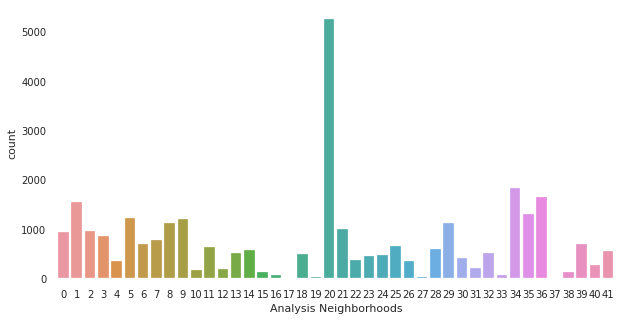

In [234]:
df['Analysis Neighborhoods'].value_counts(normalize=True,dropna=False)
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x='Analysis Neighborhoods',data=wrangler.working)

fig.show()

In [235]:
##look at negativ deltas, 
df = wrangler.working 
neg_ttr = df.ttr.map(lambda td : td.total_seconds() < 0)
df[neg_ttr]['CaseID'].nunique() ,df[neg_ttr].shape       #one record per caseid here




(329, (329, 25))

In [236]:
wrangler.working.columns


Index(['CaseID', 'Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
       'Responsible Agency', 'Category', 'Request Type', 'Request Details',
       'Address', 'Street', 'Neighborhood', 'Police District', 'Latitude',
       'Longitude', 'Source', 'Media URL', 'Current Police Districts',
       'Analysis Neighborhoods', 'Neighborhoods', 'ttr', 'case_year',
       'case_month', 'workload'],
      dtype='object')

In [237]:
wrangler.working['Request Type'].value_counts()

Bulky Items                                               5463
General Cleaning                                          4737
Encampment Reports                                        1952
Human or Animal Waste                                     1669
Graffiti on Building_commercial                            842
                                                          ... 
Building - Kitchen_Community                                 1
home_improvement_maintenance                                 1
protest_speech_bullhorns                                     1
Construction Zone Tow-away Permits for DPW CEMENT SHOP       1
Construction Zone Tow-away Permits for PUC Water Dept        1
Name: Request Type, Length: 281, dtype: int64

In [238]:
#pandas_profiling.ProfileReport(wrangler.working)
wrangler.working.Category.value_counts().index

Index(['Street and Sidewalk Cleaning', 'Graffiti', 'Abandoned Vehicle',
       'Encampments', 'Parking Enforcement', 'other', 'Damaged Property',
       'Litter Receptacles', 'Street Defects', 'Illegal Postings',
       'Homeless Concerns', 'Blocked Street or SideWalk', 'Noise Report',
       '311 External Request'],
      dtype='object')

In [239]:
wrangler.working.groupby(by=['case_year','case_month','Request Type'])[['CaseID','ttr']].agg({'CaseID': 'count'})
#produce stats by month and year
monthly_counts_by_request_type = wrangler.working.groupby(by=['case_year','case_month','Request Type']).agg({'CaseID': 'count', 'workload': np.mean, 'ttr': max})
monthly_counts_by_request_type.columns = ['case_count', 'avg_opencases', 'avg_ttr']
monthly_counts_by_request_type.sort_index(inplace=True)

monthly_counts = wrangler.working.groupby(by=['case_year','case_month']).agg({'CaseID': 'count', 'workload': np.mean, 'ttr': max})


In [240]:
monthly_counts

CaseID    workload                ttr
case_year case_month                                       
2008      7               91   17.010989  129 days 12:36:18
          8               93   23.989247  414 days 18:45:17
          9               87   24.827586 4269 days 00:36:47
          10              76   26.052632  299 days 20:04:03
          11              73   27.547945  235 days 00:55:26
...                      ...         ...                ...
2020      2              472  411.254237   97 days 20:26:39
          3              351  405.595442   64 days 04:24:48
          4              294  415.639456   56 days 14:08:53
          5              374  432.756684   32 days 22:09:44
          6               71  292.352113    2 days 18:48:00

[144 rows x 3 columns]

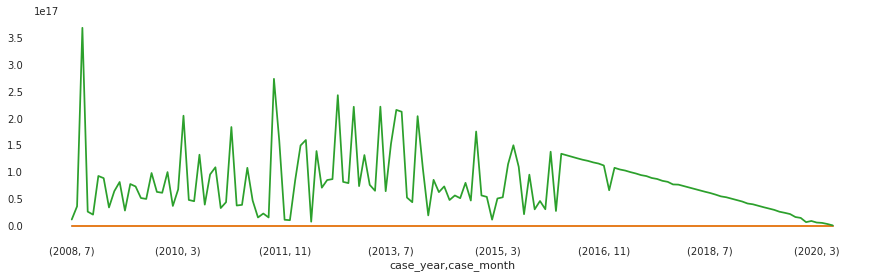

In [241]:
monthly_counts_by_request_type.loc[(2009)]

monthly_counts.columns =['case_count', 'avg_opencases', 'avg_ttr']  #wrangler.regression on this 
monthly_counts.plot(legend=False, figsize=(15,4))

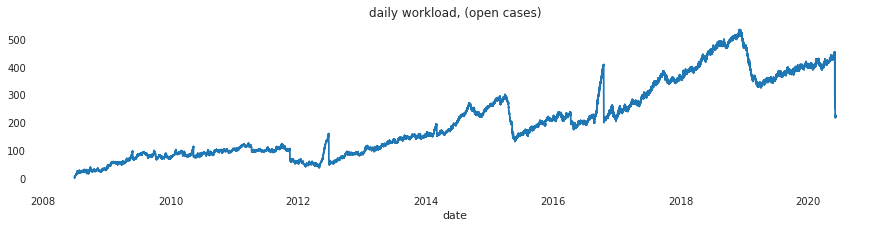

In [242]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates


daily = wrangler.working.copy()
daily['date'] = pd.DatetimeIndex(daily.Opened).date

daily_load=daily[['date','workload']]
daily_load.set_index('date',inplace=True)
daily_load.plot(legend=False, figsize=(15,3))
plt.title('daily workload, (open cases)')
plt.show()

### Linear trend within the times series :

Although the workload appears to be time serie attributes, we can see that there is a linear component as well:

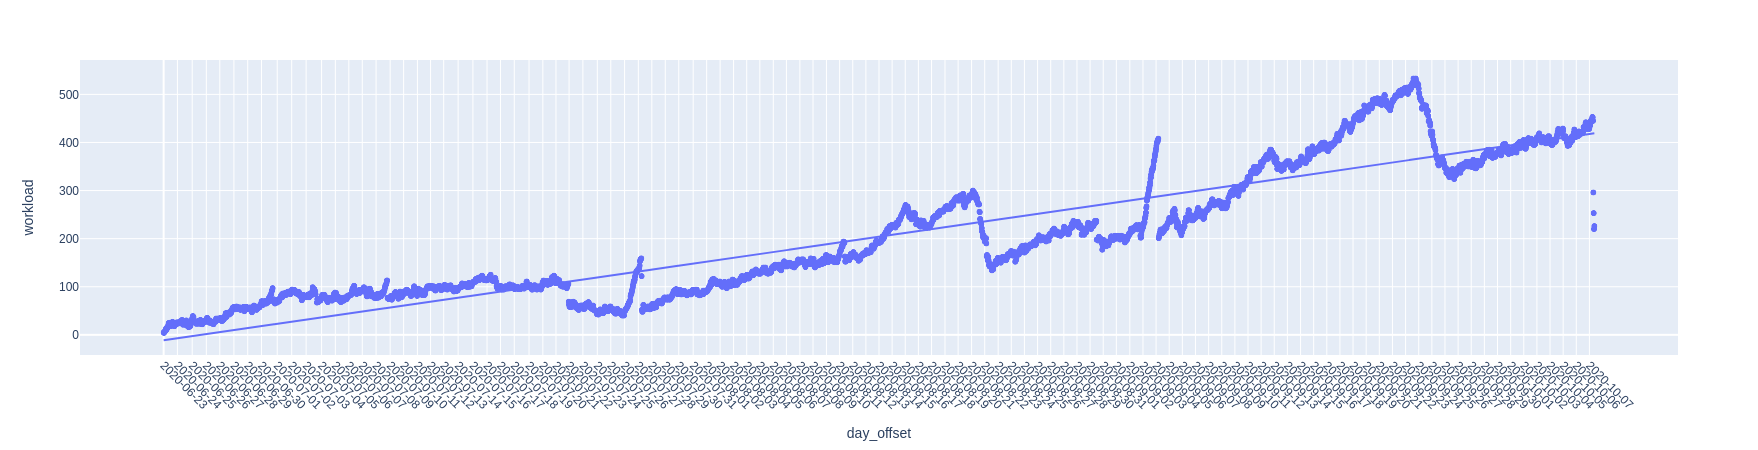

In [243]:
import plotly.express as px
from datetime import datetime

df_dl =daily_load.groupby('date').max()

df_dl['day_offset'] = (df_dl.index - df_dl.index[0]).days  #get an int represention of days since the first value


#need to create label list since we have to serialize the dates as ints for px to do the least squares
datelist = pd.date_range(datetime.today(), periods=df_dl.shape[0]).tolist()  #

fig = px.scatter(df_dl,x='day_offset', y='workload',trendline='ols')


fig.update_xaxes(tickangle=45,
                 tickmode = 'array',
                 tickvals = df_dl['day_offset'][0::40],
                 ticktext= [d.strftime('%Y-%m-%d') for d in datelist])

    
fig.show()


In [244]:
#lets see what happens if we just treat the workload as a linear regression 

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_wrangler.split
from sklearn.metrics import mean_absolute_error

train, wrangler.= train_wrangler.split(df_dl, wrangler.size=.25)      ##split by date range 
trainsize = int(df.shape[0]*.8)

X_train = train.day_offset.values.reshape(-1,1)
y_train = train.workload.values.reshape(-1,1)
X_wrangler. = wrangler.day_offset.values.reshape(-1,1)
y_wrangler. = wrangler.workload.values.reshape(-1,1)
y_pred = model.predict(X_wrangler.
model = LinearRegression()

model.fit(X_train, y_train)
print(model.coef_, model.intercept_)      #same slope calculated by px above
print(model.score(y_pred, y_wrangler., mean_absolute_error(y_pred,y_wrangler.)     #clearly regression leaves something to be desired... 



[[0.09851877]] [-9.80141455]
-2.113533185706453 43.88740098374024


In [245]:
closed_ttr_day = wrangler.working.copy()
closed_ttr_day['ttr_sec'] = closed_ttr_day['ttr']  #keep seconds
closed_ttr_day['ttr'] = closed_ttr_day['ttr'].dt.total_seconds()/3600   #convert to hours

closed_ttr_day['date_close'] = pd.DatetimeIndex(closed_ttr_day.Closed).date

closed_ttr_day = closed_ttr_day.groupby('date_close')[['CaseID','workload','ttr']].agg({'CaseID': 'count', 'workload': np.mean, 'ttr': 'mean'})
closed_ttr_day.columns=['case_count','daily_workload', 'avg_ttr_hours']


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


ax= closed_ttr_day.daily_workload.plot(figsize=(18,5))

closed_ttr_day.daily_workload.rolling(window=10).mean().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=30).mean().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=50).mean().plot(ax=ax)

closed_ttr_day.avg_ttr_hours.rolling(window=50).mean().plot(ax=ax)


ax.set_title('daily workload w /rolling avg windows')

ax.xaxis.grid(True, which='major')

ax.set_ylim(0,560)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(years_fmt)


ax.legend(['Daily Workload', 'm=10', 'm=20', 'm=30', 'ttr_hrs'])
plt.show()

AttributeError: 'DataFrame' object has no attribute 'working'

In [ ]:


ax= closed_ttr_day.daily_workload.plot(figsize=(18,5))
ax.set_title('daily workload & Variance over rolling w')

closed_ttr_day.daily_workload.rolling(window=10).var().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=30).var().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=50).var().plot(ax=ax)
closed_ttr_day.avg_ttr_hours.rolling(window=50).var().plot(ax=ax)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


ax.legend(['Daily Workload', 'm=10', 'm=20', 'm=30','mean_ttr variation'])
ax.xaxis.grid(True, which='major')

ax.set_ylim(0,1500)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
#ax.xaxis.set_xticks(months)
fig.autofmt_xdate()

plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf

x = closed_ttr_day.avg_ttr_hours
plot_acf(np.array(x),lags=50, title='mean time to resolution hrs, ACF')

plot_acf(np.array(closed_ttr_day.case_count),lags=20, title='case counts')  #check case count (open/close count) autocorrelation




In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_load.iloc[:,0].values)
print(f'p value is {result[1]}')


Since the p value is small than the significance level of 0.05, we can reject the null hypothesis that the time series data is non-stationary. Thus, the time series data is stationary.

In [ ]:
result =closed_ttr_day.iloc[:,2].values    #column is mean time to resolution in hours

print(f'p value is {result[1]}')  # this series is NOT stationary

In [ ]:
mean_ttr_by_cat = wrangler.working.groupby(['Category','Request Type']).ttr.apply(lambda x : np.mean(x))
#mean_ttr_by_cat.sort_values(ascending=False).head(5).index.tolist()
mean_ttr_by_cat.head(90)



In [ ]:
import re
from matplotlib.widgets import Slider, Button, RadioButtons

ax,ax2 = plt.subplots()
needle = '(needle)|(syringe)|(sharp)'

sharps = wrangler.working['Request Details'].str.contains(needle, case=False)
med_waste = wrangler.working['Request Type'] == 'Medical Waste'
poop = wrangler.working['Request Type'] == 'Human/Animal Waste' 
poop2 = wrangler.working['Request Details'].str.contains('Human', case=False)
camp  = wrangler.working['Request Details'].str.contains('Encampment', case=False)
wrangler.working[sharps]
wrangler.working[med_waste]

zlt = wrangler.working.Latitude == 0
zln = wrangler.working.Longitude == 0
zl =  (zln | zlt)

def update(val):
    feat = sfeat.val
    fig.canvas.draw_idle()

#ax1 = wrangler.working[poop2 & ~zl].plot(x='Longitude',y='Latitude', color='red', kind ='scatter',figsize=(10,10), title = 'SF poopmap', alpha=.5)
#ax2 = wrangler.working[med_waste & ~zl].plot(x='Longitude',y='Latitude', color='orange', kind ='scatter',figsize=(10,10), title = 'SF needles', alpha=.5)
sfeat = Slider(ax, 'Feature', poop, camp, needle, valinit=needle)

ax = wrangler.working[feat & ~zl].plot(x='Longitude',y='Latitude', color='orange', kind ='scatter',figsize=(10,10), title = 'SF needles', alpha=.5)


    
sfeat.on_changed(update)


def reset(event):
    sfeat.reset()
button.on_clicked(reset)
fig, ax = plt.subplots()